In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import importlib
import features
importlib.reload(features)
from features import lag_day
from features import lag_avg
from features import calendar_fillzero

from datetime import date

In [63]:
import os
os.getcwd()

'c:\\Users\\mertk\\Documents\\Python DS\\Ecommerce_data\\E-commerce_dataset'

* Clustering for products and customers will be done
* Prediction for total units and total price will be done
* Prediction for whether a product will be returned or not will be done

# Data Cleaning

In [2]:
data = pd.read_csv("data.csv", encoding = "cp1252")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [3]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Month'] = data['InvoiceDate'].dt.month
data['WeekdayNum'] = data['InvoiceDate'].dt.weekday
data['WeekdayName'] = data['InvoiceDate'].dt.day_name()
data['Week'] = data['InvoiceDate'].dt.isocalendar().week

In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,2,Wednesday,48
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2,Wednesday,48
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12,2,Wednesday,48
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2,Wednesday,48
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2,Wednesday,48


In [4]:
data['InvoiceDate'].min() # '2010-12-01 08:26:00'
data['InvoiceDate'].max() # '2011-12-09 12:50:00'

Timestamp('2011-12-09 12:50:00')

In [107]:
data['Quantity'].describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [4]:
data[(data['Quantity'] == 80995) | (data['Quantity'] == -80995)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,12,4,Friday,49
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,12,4,Friday,49


In [5]:
data[(data['InvoiceNo'].str.startswith('C')) & (data['Quantity'] > 0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week


In [6]:
data[(~data['InvoiceNo'].str.startswith('C')) & (data['Quantity'] < 0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom,12,2,Wednesday,48
4347,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.0,NaN,United Kingdom,12,3,Thursday,48
7188,536996,22712,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,12,4,Friday,48
7189,536997,22028,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,12,4,Friday,48
7190,536998,85067,NaN,-6,2010-12-03 15:30:00,0.0,NaN,United Kingdom,12,4,Friday,48
...,...,...,...,...,...,...,...,...,...,...,...,...
535333,581210,23395,check,-26,2011-12-07 18:36:00,0.0,NaN,United Kingdom,12,2,Wednesday,49
535335,581212,22578,lost,-1050,2011-12-07 18:38:00,0.0,NaN,United Kingdom,12,2,Wednesday,49
535336,581213,22576,check,-30,2011-12-07 18:38:00,0.0,NaN,United Kingdom,12,2,Wednesday,49
536908,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,NaN,United Kingdom,12,3,Thursday,49


In [111]:
data[(data['StockCode'] == "21777")]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week
19,536367,21777,RECIPE BOX WITH METAL HEART,4,2010-12-01 08:34:00,7.95,13047.0,United Kingdom,12,2,Wednesday,48
2140,536562,21777,RECIPE BOX WITH METAL HEART,2,2010-12-01 15:08:00,7.95,13468.0,United Kingdom,12,2,Wednesday,48
2399,536588,21777,RECIPE BOX WITH METAL HEART,1,2010-12-01 16:49:00,7.95,17069.0,United Kingdom,12,2,Wednesday,48
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.00,NaN,United Kingdom,12,2,Wednesday,48
2587,536592,21777,RECIPE BOX WITH METAL HEART,2,2010-12-01 17:06:00,7.95,NaN,United Kingdom,12,2,Wednesday,48
10350,537237,21777,RECIPE BOX WITH METAL HEART,1,2010-12-06 09:58:00,7.95,NaN,United Kingdom,12,0,Monday,49
11104,537240,21777,RECIPE BOX WITH METAL HEART,2,2010-12-06 10:08:00,7.95,NaN,United Kingdom,12,0,Monday,49
12008,537361,21777,NaN,5,2010-12-06 12:34:00,0.00,NaN,United Kingdom,12,0,Monday,49
21702,C538112,21777,RECIPE BOX WITH METAL HEART,-3,2010-12-09 15:28:00,7.95,14898.0,United Kingdom,12,3,Thursday,49
21750,C538119,21777,RECIPE BOX WITH METAL HEART,-2,2010-12-09 15:34:00,7.95,13136.0,United Kingdom,12,3,Thursday,49


In [113]:
data['InvoiceNo'].str[:1].unique()

array(['5', 'C', 'A'], dtype=object)

In [114]:
data[data['InvoiceNo'].str.startswith('A')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom,8,4,Friday,32
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,8,4,Friday,32
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,8,4,Friday,32


In [4]:
data = data[~data['InvoiceNo'].str.startswith('A')]

In [5]:
def shopping_status(x):
    if x['InvoiceNo'].startswith('C'):
        return 'Canceled'
    elif (~x['InvoiceNo'].startswith('C') and x['Quantity'] < 0) or x['UnitPrice'] == 0:
        return 'Failed'
    else:
        return 'Completed'

data['status'] = data.apply(shopping_status, axis = 1)

C:\Users\mertk\AppData\Local\Temp\ipykernel_17428\180348827.py:4: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  elif (~x['InvoiceNo'].startswith('C') and x['Quantity'] < 0) or x['UnitPrice'] == 0:


In [15]:
data[(data['Quantity'] == 0) | (data['UnitPrice'] == 0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom,12,2,Wednesday,48,Failed
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom,12,2,Wednesday,48,Failed
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,12,2,Wednesday,48,Failed
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,12,2,Wednesday,48,Failed
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom,12,2,Wednesday,48,Failed
...,...,...,...,...,...,...,...,...,...,...,...,...,...
536981,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,NaN,United Kingdom,12,3,Thursday,49,Failed
538504,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,2011-12-08 13:58:00,0.0,NaN,United Kingdom,12,3,Thursday,49,Failed
538505,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,2011-12-08 13:58:00,0.0,NaN,United Kingdom,12,3,Thursday,49,Failed
538554,581408,85175,NaN,20,2011-12-08 14:06:00,0.0,NaN,United Kingdom,12,3,Thursday,49,Failed


In [6]:
data['status'].value_counts()

status
Completed    530103
Canceled       9288
Failed         2515
Name: count, dtype: int64

In [6]:
data_completed = data[data['status'] == 'Completed']
data_canceled = data[data['status'] == 'Canceled']
data_failed = data[data['status'] == 'Failed']

In [7]:
data_completed = data_completed.sort_values('InvoiceDate')

In [ ]:
sum(data_canceled['CustomerID'].isna()) # 383
sum(data_completed['CustomerID'].isna()) # 132219
len(data_completed) # 530103
sum(data_canceled['StockCode'].isna()) # 0
sum(data_completed['StockCode'].isna()) # 0
sum(data_canceled['Description'].isna()) # 0
sum(data_completed['Description'].isna()) # 0
sum(data_failed['Description'].isna()) # 1454

1454

In [8]:
data_completed_wona = data_completed[~data_completed['CustomerID'].isna()]
data_canceled_wona = data_canceled[~data_canceled['CustomerID'].isna()]

In [9]:
quantity_daily = data_completed.groupby('InvoiceDate')['Quantity'].sum()

price_daily = data_completed.copy()
price_daily['total_cost'] = price_daily['Quantity']*price_daily['UnitPrice']
price_daily = price_daily.groupby('InvoiceDate')['total_cost'].sum()

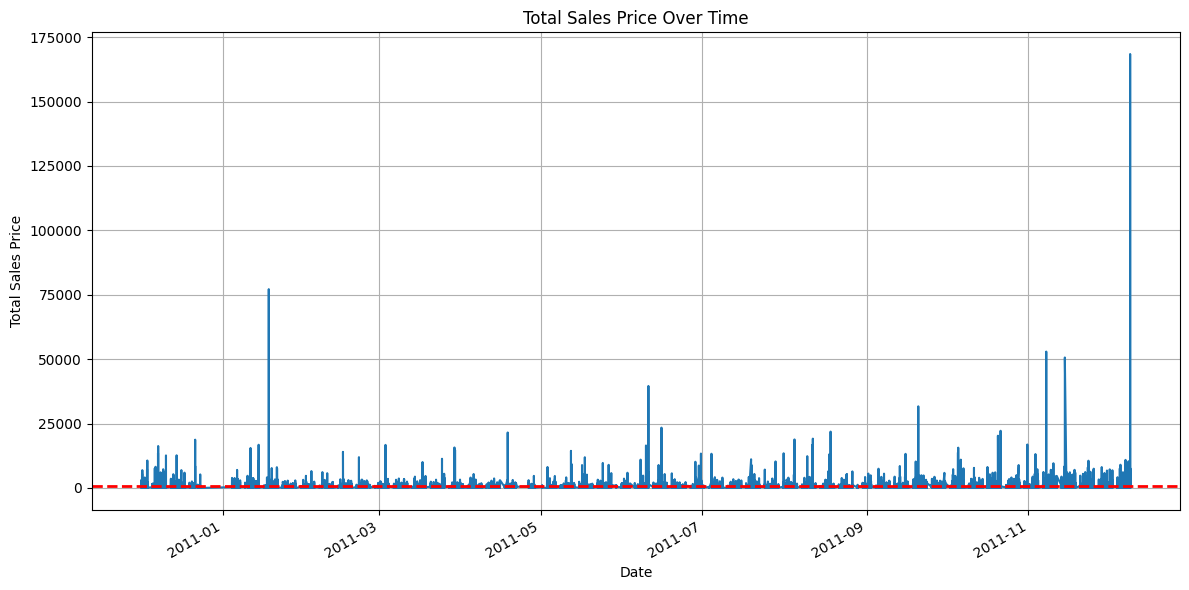

In [10]:
plt.figure(figsize=(12, 6))
price_daily.plot()
plt.axhline(y=price_daily.mean(), color='red', linestyle='--', linewidth=2, label='Mean')

plt.title("Total Sales Price Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales Price")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
price_daily.mean()

576.010729444835

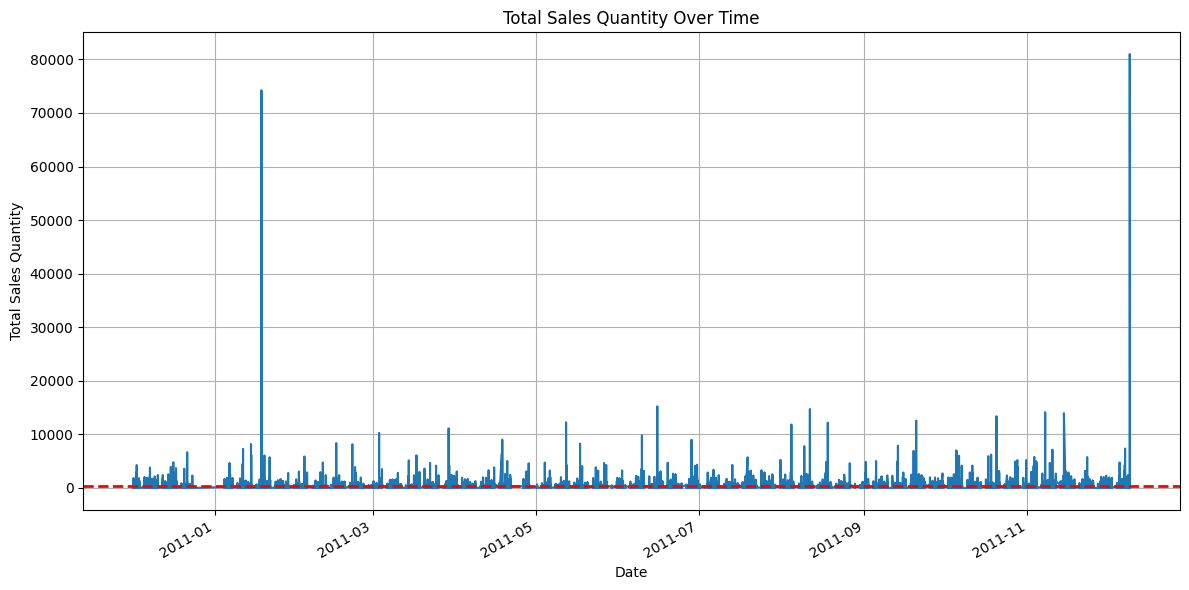

In [12]:
plt.figure(figsize = (12,6))
quantity_daily.plot()
plt.axhline(y = quantity_daily.mean(), color='red', linestyle='--', linewidth=2, label='Mean')

plt.title("Total Sales Quantity Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales Quantity")
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# there seems to be two outlier dates this is probably because I double count returned ones in complete cases as well
data_completed[data_completed['Quantity'] > 5000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,1,1,Tuesday,3,Completed
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,12,4,Friday,49,Completed


In [23]:
data_completed[data_completed['Quantity'] > 1000]['Week'].value_counts()

Week
49    10
48     8
2      7
38     6
16     5
13     4
43     4
6      4
30     3
17     3
31     3
45     3
44     3
23     3
7      3
40     3
11     3
35     2
39     2
27     2
21     2
8      2
15     2
3      2
9      2
19     2
5      2
41     1
46     1
50     1
51     1
42     1
22     1
14     1
34     1
33     1
18     1
29     1
47     1
Name: count, dtype: Int64

In [25]:
data_completed[data_completed['UnitPrice'] == 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status


In [26]:
data_canceled[(data_canceled['Quantity'] == -74215)|(data_canceled['Quantity'] == -80995)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,1,1,Tuesday,3,Canceled
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,12,4,Friday,49,Canceled


In [11]:
# there are in total of 9288 canceled items
data_canceled = data_canceled.rename(columns={'Quantity': 'return_quantity'})
data_canceled.head()

,InvoiceNo,StockCode,Description,return_quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,12,2,Wednesday,48,Canceled
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,12,2,Wednesday,48,Canceled
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,12,2,Wednesday,48,Canceled
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,12,2,Wednesday,48,Canceled
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,12,2,Wednesday,48,Canceled


In [12]:
data_canceled['Quantity'] = data_canceled['return_quantity']*-1

In [ ]:
# cancellation of stockcode = 22355, customerid = 17841.0 and quantity = 2 happened on 2010-12-01 however all of the completed ones with same constraints are after that date
# this means that not all of them are double counted
data_completed[(data_completed['StockCode'] == "22355") & (data_completed['Quantity'] == 2) & (data_completed['CustomerID'] == 17841.0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status
119473,546543,22355,CHARLOTTE BAG SUKI DESIGN,2,2011-03-14 15:40:00,0.85,17841.0,United Kingdom,3,0,Monday,11,Completed
140961,548492,22355,CHARLOTTE BAG SUKI DESIGN,2,2011-03-31 13:14:00,0.85,17841.0,United Kingdom,3,3,Thursday,13,Completed
146715,549014,22355,CHARLOTTE BAG SUKI DESIGN,2,2011-04-05 15:00:00,0.85,17841.0,United Kingdom,4,1,Tuesday,14,Completed
159733,550359,22355,CHARLOTTE BAG SUKI DESIGN,2,2011-04-18 10:41:00,0.85,17841.0,United Kingdom,4,0,Monday,16,Completed
206562,554942,22355,CHARLOTTE BAG SUKI DESIGN,2,2011-05-27 14:01:00,0.85,17841.0,United Kingdom,5,4,Friday,21,Completed
214010,555562,22355,CHARLOTTE BAG SUKI DESIGN,2,2011-06-05 14:45:00,0.85,17841.0,United Kingdom,6,6,Sunday,22,Completed
303345,563538,22355,CHARLOTTE BAG SUKI DESIGN,2,2011-08-17 11:48:00,0.85,17841.0,United Kingdom,8,2,Wednesday,33,Completed
306551,563771,22355,CHARLOTTE BAG SUKI DESIGN,2,2011-08-19 11:17:00,0.85,17841.0,United Kingdom,8,4,Friday,33,Completed
309824,564141,22355,CHARLOTTE BAG SUKI DESIGN,2,2011-08-23 11:47:00,0.85,17841.0,United Kingdom,8,1,Tuesday,34,Completed
393284,570818,22355,CHARLOTTE BAG SUKI DESIGN,2,2011-10-12 12:47:00,0.85,17841.0,United Kingdom,10,2,Wednesday,41,Completed


In [20]:
data_canceled.merge(data_completed, how = "inner", on=['CustomerID', 'StockCode', 'Quantity', 'Description'])

,InvoiceNo_x,StockCode,Description,return_quantity,InvoiceDate_x,UnitPrice_x,CustomerID,Country_x,Month_x,WeekdayNum_x,...,Quantity,InvoiceNo_y,InvoiceDate_y,UnitPrice_y,Country_y,Month_y,WeekdayNum_y,WeekdayName_y,Week_y,status_y
0,C536543,22355,CHARLOTTE BAG SUKI DESIGN,-2,2010-12-01 14:30:00,0.85,17841.0,United Kingdom,12,2,...,2,546543,2011-03-14 15:40:00,0.85,United Kingdom,3,0,Monday,11,Completed
1,C536543,22355,CHARLOTTE BAG SUKI DESIGN,-2,2010-12-01 14:30:00,0.85,17841.0,United Kingdom,12,2,...,2,548492,2011-03-31 13:14:00,0.85,United Kingdom,3,3,Thursday,13,Completed
2,C536543,22355,CHARLOTTE BAG SUKI DESIGN,-2,2010-12-01 14:30:00,0.85,17841.0,United Kingdom,12,2,...,2,549014,2011-04-05 15:00:00,0.85,United Kingdom,4,1,Tuesday,14,Completed
3,C536543,22355,CHARLOTTE BAG SUKI DESIGN,-2,2010-12-01 14:30:00,0.85,17841.0,United Kingdom,12,2,...,2,550359,2011-04-18 10:41:00,0.85,United Kingdom,4,0,Monday,16,Completed
4,C536543,22355,CHARLOTTE BAG SUKI DESIGN,-2,2010-12-01 14:30:00,0.85,17841.0,United Kingdom,12,2,...,2,554942,2011-05-27 14:01:00,0.85,United Kingdom,5,4,Friday,21,Completed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12022,C581409,23462,ROCOCO WALL MIRROR WHITE,-1,2011-12-08 14:08:00,19.95,12476.0,Germany,12,3,...,1,578472,2011-11-24 12:40:00,19.95,Germany,11,3,Thursday,47,Completed
12023,C581409,85127,SMALL SQUARE CUT GLASS CANDLESTICK,-5,2011-12-08 14:08:00,4.95,12476.0,Germany,12,3,...,5,578472,2011-11-24 12:40:00,4.95,Germany,11,3,Thursday,47,Completed
12024,C581462,16219,HOUSE SHAPE PENCIL SHARPENER,-48,2011-12-08 18:51:00,0.06,12985.0,United Kingdom,12,3,...,48,575868,2011-11-11 12:44:00,0.06,United Kingdom,11,4,Friday,45,Completed
12025,C581462,21642,ASSORTED TUTTI FRUTTI PEN,-72,2011-12-08 18:51:00,0.29,12985.0,United Kingdom,12,3,...,72,575868,2011-11-11 12:44:00,0.29,United Kingdom,11,4,Friday,45,Completed


In [21]:
# cancellation of stockcode = 21642, customerid = 12985.0 and quantity = 72 happened on 2011-12-08, completed one with same constraints are on 2011-11-11
# we have to eliminate it somehow
data_completed[(data_completed['StockCode'] == "21642") & (data_completed['Quantity'] == 72) & (data_completed['CustomerID'] == 12985.0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status
459198,575868,21642,ASSORTED TUTTI FRUTTI PEN,72,2011-11-11 12:44:00,0.29,12985.0,United Kingdom,11,4,Friday,45,Completed


In [13]:
data_intersect = data_canceled.merge(data_completed, how = "inner", on=['CustomerID', 'StockCode', 'Quantity', 'Description', 'UnitPrice'])
data_intersect = data_intersect[data_intersect['InvoiceDate_x'] > data_intersect['InvoiceDate_y']]

In [18]:
len(data_intersect) # 4267
data_intersect[['InvoiceNo_x', 'StockCode']].value_counts()

InvoiceNo_x  StockCode
C558364      22960        69
C576816      POST         17
C576195      21539        15
C568689      22212        14
C543611      21071        14
                          ..
C555636      22682         1
             22683         1
             22684         1
             22685         1
C581484      23843         1
Name: count, Length: 2879, dtype: int64

In [19]:
data_intersect[data_intersect['InvoiceNo_x'] == "C558364"]

,InvoiceNo_x,StockCode,Description,return_quantity,InvoiceDate_x,UnitPrice,CustomerID,Country_x,Month_x,WeekdayNum_x,...,status_x,Quantity,InvoiceNo_y,InvoiceDate_y,Country_y,Month_y,WeekdayNum_y,WeekdayName_y,Week_y,status_y
2645,C558364,POST,POSTAGE,-1,2011-06-28 15:20:00,3.95,NaN,United Kingdom,6,1,...,Canceled,1,548219,2011-03-30 09:46:00,United Kingdom,3,2,Wednesday,13,Completed
2646,C558364,22960,JAM MAKING SET WITH JARS,-1,2011-06-28 15:20:00,8.29,NaN,United Kingdom,6,1,...,Canceled,1,541104,2011-01-13 14:29:00,United Kingdom,1,3,Thursday,2,Completed
2647,C558364,22960,JAM MAKING SET WITH JARS,-1,2011-06-28 15:20:00,8.29,NaN,United Kingdom,6,1,...,Canceled,1,541131,2011-01-14 10:16:00,United Kingdom,1,4,Friday,2,Completed
2648,C558364,22960,JAM MAKING SET WITH JARS,-1,2011-06-28 15:20:00,8.29,NaN,United Kingdom,6,1,...,Canceled,1,541422,2011-01-17 17:48:00,United Kingdom,1,0,Monday,3,Completed
2649,C558364,22960,JAM MAKING SET WITH JARS,-1,2011-06-28 15:20:00,8.29,NaN,United Kingdom,6,1,...,Canceled,1,541423,2011-01-17 17:54:00,United Kingdom,1,0,Monday,3,Completed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2710,C558364,22960,JAM MAKING SET WITH JARS,-1,2011-06-28 15:20:00,8.29,NaN,United Kingdom,6,1,...,Canceled,1,557112,2011-06-16 16:31:00,United Kingdom,6,3,Thursday,24,Completed
2711,C558364,22960,JAM MAKING SET WITH JARS,-1,2011-06-28 15:20:00,8.29,NaN,United Kingdom,6,1,...,Canceled,1,557324,2011-06-20 09:41:00,United Kingdom,6,0,Monday,25,Completed
2712,C558364,22960,JAM MAKING SET WITH JARS,-1,2011-06-28 15:20:00,8.29,NaN,United Kingdom,6,1,...,Canceled,1,557480,2011-06-20 14:10:00,United Kingdom,6,0,Monday,25,Completed
2713,C558364,22960,JAM MAKING SET WITH JARS,-1,2011-06-28 15:20:00,8.29,NaN,United Kingdom,6,1,...,Canceled,1,557500,2011-06-20 15:27:00,United Kingdom,6,0,Monday,25,Completed


In [59]:
# again this is not the best way to eliminate them because there might be cases where someone cancelled their order but then make the same order 10 times after the cancellation this way I eliminate all of them
# the most feasible way seems to be eliminate the first order after the cancellation date with same 'CustomerID', 'StockCode', 'Quantity', 'Description', 'UnitPrice'
data_canceled[(data_canceled['Quantity'] == data_canceled[data_canceled['CustomerID'].isna()]['Quantity'].max()) & (data_canceled['CustomerID'].isna())]

,InvoiceNo,StockCode,Description,return_quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status,Quantity
133109,C547725,84929,ASSTD FRUIT+FLOWERS FRIDGE MAGNETS,-144,2011-03-25 10:43:00,0.55,NaN,United Kingdom,3,4,Friday,12,Canceled,144
133110,C547725,84929,ASSTD FRUIT+FLOWERS FRIDGE MAGNETS,-144,2011-03-25 10:43:00,0.55,NaN,United Kingdom,3,4,Friday,12,Canceled,144


In [63]:
data_completed[(data_completed['StockCode'] == "84929") & (data_completed['Description'] == "ASSTD FRUIT+FLOWERS FRIDGE MAGNETS") & (data_completed['Quantity'] == 144)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status
127392,547219,84929,ASSTD FRUIT+FLOWERS FRIDGE MAGNETS,144,2011-03-21 14:51:00,0.55,NaN,United Kingdom,3,0,Monday,12,Completed
252064,559062,84929,ASSTD FRUIT+FLOWERS FRIDGE MAGNETS,144,2011-07-06 10:09:00,0.19,13253.0,United Kingdom,7,2,Wednesday,27,Completed


In [14]:
# 'CustomerID', 'StockCode', 'Quantity', 'Description', 'UnitPrice'
data_completed['key'] = (
    pd.Series(np.where(data_completed['CustomerID'].isna(), 0, data_completed['CustomerID']), index = data_completed.index).astype(int).astype(str) + '_' +
    data_completed['StockCode'].astype(str) + '_' + 
    data_completed['Quantity'].astype(str) + '_' +
    data_completed['Description'].astype(str)
)

data_canceled['key'] = (
    pd.Series(np.where(data_canceled['CustomerID'].isna(), 0, data_canceled['CustomerID']), index = data_canceled.index).astype(int).astype(str) + '_' +
    data_canceled['StockCode'].astype(str) + '_' + 
    data_canceled['Quantity'].astype(str) + '_' + 
    data_canceled['Description'].astype(str)
)

In [25]:
data_completed[data_completed['CustomerID'].isna()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status,key
1792,536544,85231B,CINAMMON SET OF 9 T-LIGHTS,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom,12,2,Wednesday,48,Completed,0_85231B_2_CINAMMON SET OF 9 T-LIGHTS
1793,536544,85232B,SET OF 3 BABUSHKA STACKING TINS,1,2010-12-01 14:32:00,4.95,NaN,United Kingdom,12,2,Wednesday,48,Completed,0_85232B_1_SET OF 3 BABUSHKA STACKING TINS
1794,536544,90003C,MIDNIGHT BLUE PAIR HEART HAIR SLIDE,1,2010-12-01 14:32:00,3.81,NaN,United Kingdom,12,2,Wednesday,48,Completed,0_90003C_1_MIDNIGHT BLUE PAIR HEART HAIR SLIDE
1795,536544,90018A,SILVER M.O.P ORBIT DROP EARRINGS,1,2010-12-01 14:32:00,4.24,NaN,United Kingdom,12,2,Wednesday,48,Completed,0_90018A_1_SILVER M.O.P ORBIT DROP EARRINGS
1796,536544,90022,EDWARDIAN DROP EARRINGS JET BLACK,1,2010-12-01 14:32:00,3.81,NaN,United Kingdom,12,2,Wednesday,48,Completed,0_90022_1_EDWARDIAN DROP EARRINGS JET BLACK


In [15]:
data_completed = data_completed.sort_values(['InvoiceDate', 'key']).reset_index(drop=True)
data_completed['row_number'] = (data_completed.groupby('key').cumcount() + 1)

data_canceled = data_canceled.sort_values(['InvoiceDate', 'key']).reset_index(drop=True)
data_canceled['row_number'] = (data_canceled.groupby('key').cumcount() + 1)

In [29]:
data_canceled.head()

,InvoiceNo,StockCode,Description,return_quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status,Quantity,key,row_number
0,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,12,2,Wednesday,48,Canceled,1,14527_D_1_Discount,1
1,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,12,2,Wednesday,48,Canceled,1,15311_35004C_1_SET OF 3 COLOURED FLYING DUCKS,1
2,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom,12,2,Wednesday,48,Canceled,12,17548_21484_12_CHICK GREY HOT WATER BOTTLE,1
3,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,12,2,Wednesday,48,Canceled,24,17548_21980_24_PACK OF 12 RED RETROSPOT TISSUES,1
4,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,12,2,Wednesday,48,Canceled,24,17548_21983_24_PACK OF 12 BLUE PAISLEY TISSUES,1


In [30]:
data_completed.merge(data_canceled, how = 'inner', on = ['key', 'row_number'])

,InvoiceNo_x,StockCode_x,Description_x,Quantity_x,InvoiceDate_x,UnitPrice_x,CustomerID_x,Country_x,Month_x,WeekdayNum_x,...,InvoiceDate_y,UnitPrice_y,CustomerID_y,Country_y,Month_y,WeekdayNum_y,WeekdayName_y,Week_y,status_y,Quantity_y
0,536373,21071,VINTAGE BILLBOARD DRINK ME MUG,6,2010-12-01 09:02:00,1.06,17850.0,United Kingdom,12,2,...,2011-02-10 14:38:00,1.06,17850.0,United Kingdom,2,3,Thursday,6,Canceled,6
1,536373,82483,WOOD 2 DRAWER CABINET WHITE FINISH,2,2010-12-01 09:02:00,4.95,17850.0,United Kingdom,12,2,...,2011-02-10 14:38:00,4.95,17850.0,United Kingdom,2,3,Thursday,6,Canceled,2
2,536381,22778,GLASS CLOCHE SMALL,3,2010-12-01 09:41:00,3.95,15311.0,United Kingdom,12,2,...,2011-11-15 13:22:00,3.39,15311.0,United Kingdom,11,1,Tuesday,46,Canceled,3
3,536390,85099B,JUMBO BAG RED RETROSPOT,100,2010-12-01 10:19:00,1.65,17511.0,United Kingdom,12,2,...,2011-11-09 11:41:00,1.79,17511.0,United Kingdom,11,2,Wednesday,45,Canceled,100
4,536396,82494L,WOODEN FRAME ANTIQUE WHITE,12,2010-12-01 10:51:00,2.55,17850.0,United Kingdom,12,2,...,2011-02-10 14:38:00,2.55,17850.0,United Kingdom,2,3,Thursday,6,Canceled,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3378,581412,21733,RED HANGING HEART T-LIGHT HOLDER,1,2011-12-08 14:38:00,2.95,14415.0,United Kingdom,12,3,...,2011-07-01 17:02:00,2.95,14415.0,United Kingdom,7,4,Friday,26,Canceled,1
3379,581469,21485,RETROSPOT HEART HOT WATER BOTTLE,1,2011-12-08 19:28:00,4.95,14606.0,United Kingdom,12,3,...,2011-09-07 12:48:00,4.95,14606.0,United Kingdom,9,2,Wednesday,36,Canceled,1
3380,581469,84029E,RED WOOLLY HOTTIE WHITE HEART.,1,2011-12-08 19:28:00,4.25,14606.0,United Kingdom,12,3,...,2011-09-07 12:48:00,4.25,14606.0,United Kingdom,9,2,Wednesday,36,Canceled,1
3381,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,12,4,...,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,12,4,Friday,49,Canceled,80995


In [165]:
data_canceled[(data_canceled['Quantity'] == data_canceled[data_canceled['CustomerID'].isna()]['Quantity'].max()) & (data_canceled['CustomerID'].isna())]['key']

133109    0_84929_144_ASSTD FRUIT+FLOWERS FRIDGE MAGNETS
133110    0_84929_144_ASSTD FRUIT+FLOWERS FRIDGE MAGNETS
Name: key, dtype: object

In [166]:
data_completed[data_completed['key'] == "0_84929_144"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status,key,row_number


In [167]:
data_canceled[~data_canceled['key'].isin(data_completed['key'])]

,InvoiceNo,StockCode,Description,return_quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status,Quantity,key,row_number
196505,C553854,22053,EMPIRE DESIGN ROSETTE,-1,2011-05-19 13:13:00,1.25,NaN,United Kingdom,5,3,Thursday,20,Canceled,1,0_22053_1_EMPIRE DESIGN ROSETTE,1
82039,C543185,22332,SKULLS PARTY BAG + STICKER SET,-14,2011-02-04 11:22:00,1.65,NaN,United Kingdom,2,4,Friday,5,Canceled,14,0_22332_14_SKULLS PARTY BAG + STICKER SET,1
82038,C543185,22333,RETROSPOT PARTY BAG + STICKER SET,-14,2011-02-04 11:22:00,1.65,NaN,United Kingdom,2,4,Friday,5,Canceled,14,0_22333_14_RETROSPOT PARTY BAG + STICKER SET,1
11508,C537251,22454,MEASURING TAPE BABUSHKA RED,-8,2010-12-06 10:45:00,2.95,NaN,United Kingdom,12,0,Monday,49,Canceled,8,0_22454_8_MEASURING TAPE BABUSHKA RED,1
11505,C537251,22564,ALPHABET STENCIL CRAFT,-5,2010-12-06 10:45:00,1.25,NaN,United Kingdom,12,0,Monday,49,Canceled,5,0_22564_5_ALPHABET STENCIL CRAFT,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184924,C552720,84817,DANISH ROSE DECORATIVE PLATE,-2,2011-05-11 09:49:00,2.10,18272.0,United Kingdom,5,2,Wednesday,19,Canceled,2,18272_84817_2_DANISH ROSE DECORATIVE PLATE,1
481908,C577386,23401,RUSTIC MIRROR WITH LACE HEART,-1,2011-11-18 16:54:00,6.25,18276.0,United Kingdom,11,4,Friday,46,Canceled,1,18276_23401_1_RUSTIC MIRROR WITH LACE HEART,1
481921,C577390,23401,RUSTIC MIRROR WITH LACE HEART,-1,2011-11-18 17:01:00,6.25,18276.0,United Kingdom,11,4,Friday,46,Canceled,1,18276_23401_1_RUSTIC MIRROR WITH LACE HEART,2
70604,C542086,22423,REGENCY CAKESTAND 3 TIER,-1,2011-01-25 12:34:00,12.75,18277.0,United Kingdom,1,1,Tuesday,4,Canceled,1,18277_22423_1_REGENCY CAKESTAND 3 TIER,1


In [168]:
# there is a cancel for same stock code and same quantity however customerID is null for return
# the one we observe here has customerID so there is no way to distinguish them we cannot eliminate this record from the completed cases
data_completed[(data_completed['StockCode'] == "22053") & (data_completed['Quantity'] == 1)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status,key,row_number
448784,575070,22053,EMPIRE DESIGN ROSETTE,1,2011-11-08 12:58:00,1.25,17841.0,United Kingdom,11,1,Tuesday,45,Completed,17841_22053_1_EMPIRE DESIGN ROSETTE,1


In [16]:
# data_intersect = data_completed.merge(data_canceled, how = 'inner', on = ['key', 'row_number'])
# data_intersect = data_intersect[data_intersect['InvoiceDate_x'] < data_intersect['InvoiceDate_y']]
# data_intersect

data_intersect = pd.merge_asof(
    data_completed,
    data_canceled,
    by='key',
    left_on='InvoiceDate',
    right_on='InvoiceDate',
    direction='forward'
)

In [32]:
data_intersect[data_intersect['Quantity_x'] > 5000]

,InvoiceNo_x,StockCode_x,Description_x,Quantity_x,InvoiceDate,UnitPrice_x,CustomerID_x,Country_x,Month_x,WeekdayNum_x,...,UnitPrice_y,CustomerID_y,Country_y,Month_y,WeekdayNum_y,WeekdayName_y,Week_y,status_y,Quantity_y,row_number_y
60250,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,1,1,...,1.04,12346.0,United Kingdom,1.0,1.0,Tuesday,3,Canceled,74215.0,1.0
528622,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,12,4,...,2.08,16446.0,United Kingdom,12.0,4.0,Friday,49,Canceled,80995.0,1.0


In [32]:
data_intersect.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530103 entries, 0 to 530102
Data columns (total 29 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   InvoiceNo_x      530103 non-null  object        
 1   StockCode_x      530103 non-null  object        
 2   Description_x    530103 non-null  object        
 3   Quantity_x       530103 non-null  int64         
 4   InvoiceDate      530103 non-null  datetime64[ns]
 5   UnitPrice_x      530103 non-null  float64       
 6   CustomerID_x     397884 non-null  float64       
 7   Country_x        530103 non-null  object        
 8   Month_x          530103 non-null  int32         
 9   WeekdayNum_x     530103 non-null  int32         
 10  WeekdayName_x    530103 non-null  object        
 11  Week_x           530103 non-null  UInt32        
 12  status_x         530103 non-null  object        
 13  key              530103 non-null  object        
 14  row_number_x     530

In [67]:
data_intersect[data_intersect['StockCode_y'].isna()].head()

,InvoiceNo_x,StockCode_x,Description_x,Quantity_x,InvoiceDate,UnitPrice_x,CustomerID_x,Country_x,Month_x,WeekdayNum_x,...,UnitPrice_y,CustomerID_y,Country_y,Month_y,WeekdayNum_y,WeekdayName_y,Week_y,status_y,Quantity_y,row_number_y
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,12,2,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,12,2,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN
2,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN


In [68]:
data_intersect[~data_intersect['StockCode_y'].isna()].index

Index([    51,     58,     70,     77,    130,    231,    272,    280,    282,
          296,
       ...
       508331, 508339, 515751, 522982, 522983, 523022, 523023, 525825, 525836,
       528622],
      dtype='int64', length=5132)

In [17]:
# merged = data_completed.merge(data_intersect, how = "left", on = ['key', 'row_number'], indicator = True)
# data_completed_final = merged[merged['_merge'] == 'left_only']

data_completed_final = data_completed.loc[data_intersect[data_intersect['StockCode_y'].isna()].index]

In [24]:
len(data_completed_final) # 524971, 530103(total completed transactions) - 5132(matching table) = 524971

524971

In [25]:
# calculate price per shopping, quantity per shopping, calculate frequency, create a variable for recency
data_completed_final.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status,key,row_number
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,12,2,Wednesday,48,Completed,17850_21730_6_GLASS STAR FROSTED T-LIGHT HOLDER,1
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,12,2,Wednesday,48,Completed,17850_22752_2_SET 7 BABUSHKA NESTING BOXES,1
2,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2,Wednesday,48,Completed,17850_71053_6_WHITE METAL LANTERN,1
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2,Wednesday,48,Completed,17850_84029E_6_RED WOOLLY HOTTIE WHITE HEART.,1
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2,Wednesday,48,Completed,17850_84029G_6_KNITTED UNION FLAG HOT WATER BO...,1


In [26]:
data_completed_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 524971 entries, 0 to 530102
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    524971 non-null  object        
 1   StockCode    524971 non-null  object        
 2   Description  524971 non-null  object        
 3   Quantity     524971 non-null  int64         
 4   InvoiceDate  524971 non-null  datetime64[ns]
 5   UnitPrice    524971 non-null  float64       
 6   CustomerID   393841 non-null  float64       
 7   Country      524971 non-null  object        
 8   Month        524971 non-null  int32         
 9   WeekdayNum   524971 non-null  int32         
 10  WeekdayName  524971 non-null  object        
 11  Week         524971 non-null  UInt32        
 12  status       524971 non-null  object        
 13  key          524971 non-null  object        
 14  row_number   524971 non-null  int64         
dtypes: UInt32(1), datetime64[ns](1), float6

In [72]:
data_completed_final['Quantity'].describe()

count    524971.000000
mean         10.160634
std          37.030157
min           1.000000
25%           1.000000
50%           3.000000
75%          10.000000
max        4800.000000
Name: Quantity, dtype: float64

In [73]:
# this is actually belong to completed transaction so there is nothing wrong here.
data_completed_final[data_completed_final['Quantity'] == 4800]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status,key,row_number
411722,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901.0,United Kingdom,10,3,Thursday,43,Completed,12901_84077_4800_WORLD WAR 2 GLIDERS ASSTD DES...,1


In [74]:
data_canceled[data_canceled['StockCode'] == "84077"]

,InvoiceNo,StockCode,Description,return_quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status,Quantity,key,row_number
2695,C548972,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,-48,2011-04-05 11:42:00,0.29,15674.0,United Kingdom,4,1,Tuesday,14,Canceled,48,15674_84077_48_WORLD WAR 2 GLIDERS ASSTD DESIGNS,1
3104,C551180,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,-48,2011-04-26 17:32:00,0.29,14586.0,United Kingdom,4,1,Tuesday,17,Canceled,48,14586_84077_48_WORLD WAR 2 GLIDERS ASSTD DESIGNS,1
3321,C552568,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,-960,2011-05-10 12:04:00,0.21,12901.0,United Kingdom,5,1,Tuesday,19,Canceled,960,12901_84077_960_WORLD WAR 2 GLIDERS ASSTD DESIGNS,1
3722,C554793,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,-96,2011-05-26 12:41:00,0.11,12901.0,United Kingdom,5,3,Thursday,21,Canceled,96,12901_84077_96_WORLD WAR 2 GLIDERS ASSTD DESIGNS,1
5162,C561649,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,-48,2011-07-28 15:27:00,0.29,15746.0,United Kingdom,7,3,Thursday,30,Canceled,48,15746_84077_48_WORLD WAR 2 GLIDERS ASSTD DESIGNS,1


In [18]:
data_completed_final['total_cost'] = data_completed_final['Quantity']*data_completed_final['UnitPrice']

In [76]:
data_completed_final['UnitPrice'].describe()

count    524971.000000
mean          3.683636
std          23.090298
min           0.001000
25%           1.250000
50%           2.080000
75%           4.130000
max        8142.750000
Name: UnitPrice, dtype: float64

In [77]:
data_completed_final['total_cost'].describe()

count    524971.000000
mean         19.250403
std          85.672182
min           0.001000
25%           3.750000
50%           9.900000
75%          17.700000
max       38970.000000
Name: total_cost, dtype: float64

In [78]:
data_completed_final[(data_completed_final['StockCode'] == "22502") & (data_completed_final['Quantity'] == 60)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status,key,row_number,total_cost
217306,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.5,15098.0,United Kingdom,6,4,Friday,23,Completed,15098_22502_60_PICNIC BASKET WICKER 60 PIECES,1,38970.0


In [79]:
data_completed[(data_completed['StockCode'] == "22502") & (data_completed['Quantity'] == 60)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status,key,row_number
217296,556442,22502,PICNIC BASKET WICKER SMALL,60,2011-06-10 15:22:00,4.95,15098.0,United Kingdom,6,4,Friday,23,Completed,15098_22502_60_PICNIC BASKET WICKER SMALL,1
217306,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,6,4,Friday,23,Completed,15098_22502_60_PICNIC BASKET WICKER 60 PIECES,1


In [80]:
# we excluded the correct one the remaining should stay in the completed transactions
data_canceled[data_canceled['StockCode'] == "22502"]

,InvoiceNo,StockCode,Description,return_quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status,Quantity,key,row_number
2170,C546529,22502,PICNIC BASKET WICKER SMALL,-1,2011-03-14 13:05:00,5.95,15502.0,United Kingdom,3,0,Monday,11,Canceled,1,15502_22502_1_PICNIC BASKET WICKER SMALL,1
2232,C546893,22502,PICNIC BASKET WICKER SMALL,-1,2011-03-17 18:20:00,4.95,14156.0,EIRE,3,3,Thursday,11,Canceled,1,14156_22502_1_PICNIC BASKET WICKER SMALL,1
2565,C548467,22502,PICNIC BASKET WICKER SMALL,-2,2011-03-31 12:20:00,5.95,16619.0,United Kingdom,3,3,Thursday,13,Canceled,2,16619_22502_2_PICNIC BASKET WICKER SMALL,1
2691,C548972,22502,PICNIC BASKET WICKER SMALL,-4,2011-04-05 11:42:00,5.95,15674.0,United Kingdom,4,1,Tuesday,14,Canceled,4,15674_22502_4_PICNIC BASKET WICKER SMALL,1
3295,C552535,22502,PICNIC BASKET WICKER SMALL,-1,2011-05-10 09:59:00,5.95,13269.0,United Kingdom,5,1,Tuesday,19,Canceled,1,13269_22502_1_PICNIC BASKET WICKER SMALL,1
3488,C553561,22502,PICNIC BASKET WICKER SMALL,-1,2011-05-17 17:24:00,5.95,15596.0,United Kingdom,5,1,Tuesday,20,Canceled,1,15596_22502_1_PICNIC BASKET WICKER SMALL,1
3678,C554530,22502,PICNIC BASKET WICKER SMALL,-1,2011-05-24 17:28:00,5.95,15596.0,United Kingdom,5,1,Tuesday,21,Canceled,1,15596_22502_1_PICNIC BASKET WICKER SMALL,2
4015,C556448,22502,PICNIC BASKET WICKER SMALL,-60,2011-06-10 15:39:00,4.95,15098.0,United Kingdom,6,4,Friday,23,Canceled,60,15098_22502_60_PICNIC BASKET WICKER SMALL,1
4074,C556647,22502,PICNIC BASKET WICKER SMALL,-4,2011-06-13 16:14:00,5.95,13012.0,United Kingdom,6,0,Monday,24,Canceled,4,13012_22502_4_PICNIC BASKET WICKER SMALL,1


# Explaratory Data Analysis

In [19]:
data_completed_final['InvoiceDate_only'] = data_completed_final['InvoiceDate'].dt.date
data_completed_final = data_completed_final.sort_values('InvoiceDate_only')

In [20]:
quantity_daily = data_completed_final.groupby('InvoiceDate_only')['Quantity'].sum()

price_daily = data_completed_final.groupby('InvoiceDate_only')['total_cost'].sum()

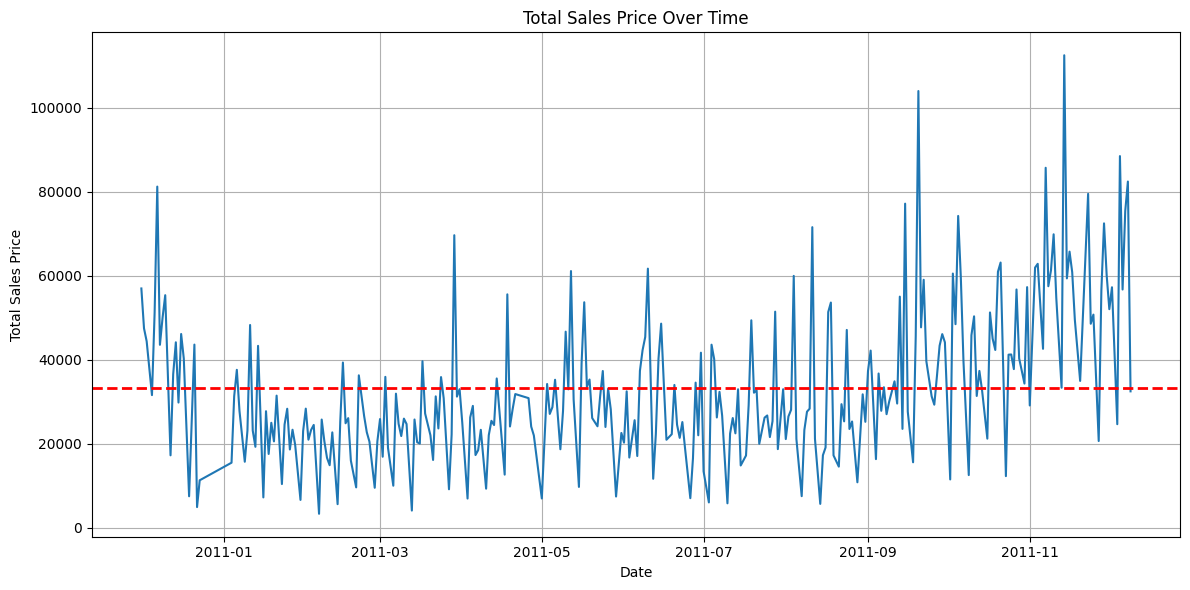

In [21]:
plt.figure(figsize=(12, 6))
price_daily.plot()
plt.axhline(y=price_daily.mean(), color='red', linestyle='--', linewidth=2, label='Mean')

plt.title("Total Sales Price Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales Price")
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
price_daily[price_daily > 90000]

InvoiceDate_only
2011-09-20    104003.92
2011-11-14    112528.86
Name: total_cost, dtype: float64

In [23]:
data_intersect[data_intersect['StockCode_x'] == "AMAZONFEE"]

,InvoiceNo_x,StockCode_x,Description_x,Quantity_x,InvoiceDate,UnitPrice_x,CustomerID_x,Country_x,Month_x,WeekdayNum_x,...,UnitPrice_y,CustomerID_y,Country_y,Month_y,WeekdayNum_y,WeekdayName_y,Week_y,status_y,Quantity_y,row_number_y
14715,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,NaN,United Kingdom,12,1,...,13474.79,NaN,United Kingdom,12.0,1.0,Tuesday,49,Canceled,1.0,3.0
132376,547901,AMAZONFEE,AMAZON FEE,1,2011-03-28 11:57:00,219.76,NaN,United Kingdom,3,0,...,219.76,NaN,United Kingdom,3.0,0.0,Monday,13,Canceled,1.0,13.0


In [86]:
data_completed_final[data_completed_final['UnitPrice'] == data_completed_final['UnitPrice'].max()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status,key,row_number,total_cost,InvoiceDate_only
169097,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom,5,1,Tuesday,18,Completed,16029_POST_1_POSTAGE,1,8142.75,2011-05-03


In [89]:
data_canceled[data_canceled['key'] == "16029_POST_1_POSTAGE"]

,InvoiceNo,StockCode,Description,return_quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status,Quantity,key,row_number
3201,C551685,POST,POSTAGE,-1,2011-05-03 12:51:00,8142.75,16029.0,United Kingdom,5,1,Tuesday,18,Canceled,1,16029_POST_1_POSTAGE,1


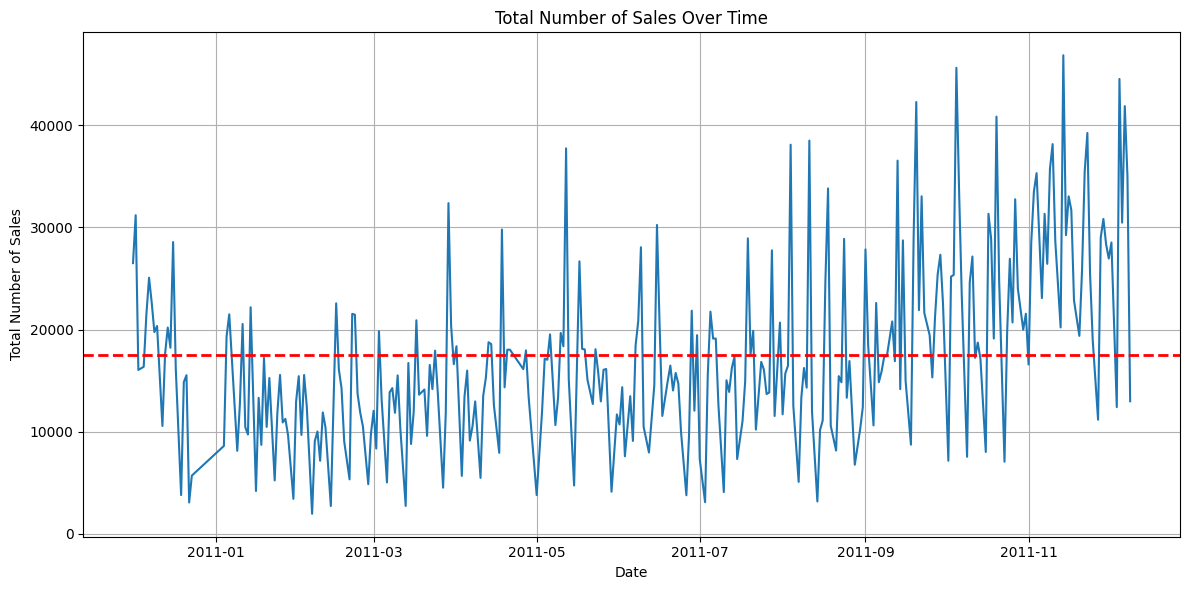

In [24]:
plt.figure(figsize=(12, 6))
quantity_daily.plot()
plt.axhline(y=quantity_daily.mean(), color='red', linestyle='--', linewidth=2, label='Mean')

plt.title("Total Number of Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Number of Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

In [100]:
data_completed_final['InvoiceDate_only'].value_counts().head(10)

InvoiceDate_only
2011-12-05    5296
2011-12-08    4865
2011-11-29    4286
2011-11-16    4133
2011-11-11    4050
2011-11-08    3969
2011-11-22    3897
2010-12-06    3775
2011-11-24    3671
2011-11-17    3570
Name: count, dtype: int64

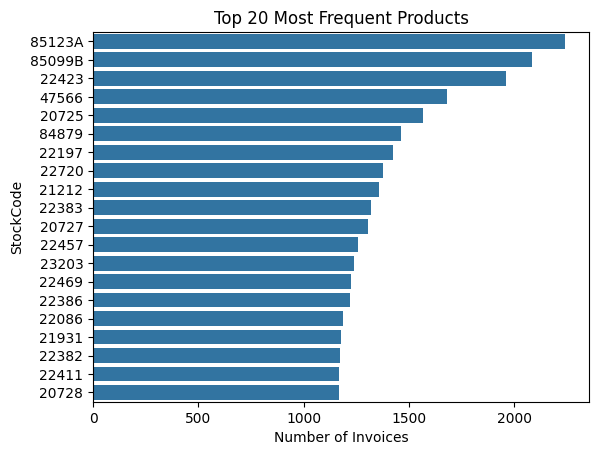

In [25]:
# top 20 most sold products
most_freq_products = data_completed_final.groupby('StockCode')['InvoiceNo'].count()
most_freq_products = most_freq_products.sort_values(ascending=False)
sns.barplot(y = most_freq_products[:20].index, x = most_freq_products[:20].values)
plt.xlabel("Number of Invoices")
plt.ylabel("StockCode")
plt.title("Top 20 Most Frequent Products")
plt.show()

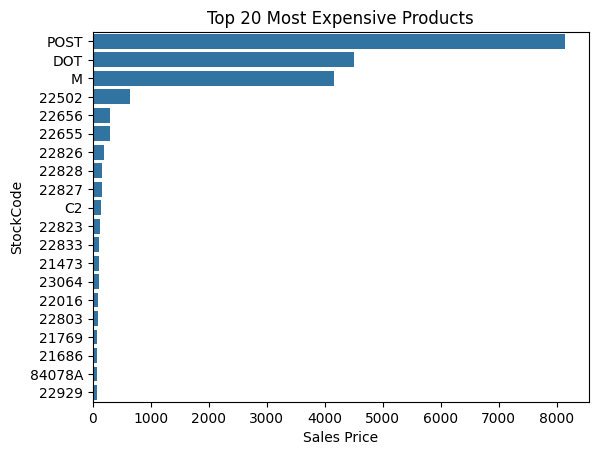

In [26]:
# top 20 most expensive products
most_expensive_products = data_completed_final.groupby('StockCode')['UnitPrice'].max()
most_expensive_products = most_expensive_products.sort_values(ascending=False)
most_expensive_products

sns.barplot(y = most_expensive_products[:20].index, x = most_expensive_products[:20].values)
plt.xlabel("Sales Price")
plt.ylabel("StockCode")
plt.title("Top 20 Most Expensive Products")
plt.show()

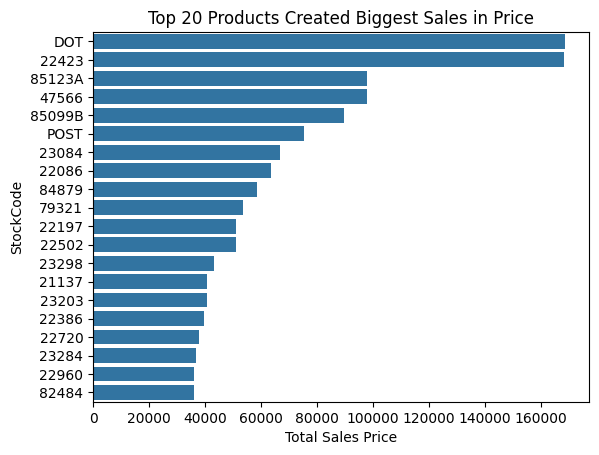

In [27]:
# top 20 products that generated the biggest sales in terms of costs
most_cost_products = data_completed_final.groupby('StockCode')['total_cost'].sum()
most_cost_products = most_cost_products.sort_values(ascending=False)
most_cost_products

sns.barplot(y = most_cost_products[:20].index, x = most_cost_products[:20].values)
plt.xlabel("Total Sales Price")
plt.ylabel("StockCode")
plt.title("Top 20 Products Created Biggest Sales in Price")
plt.show()

In [38]:
data_completed_final[(data_completed_final['StockCode'] == 'DOT') & (~data_completed_final['CustomerID'].isna())]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status,key,row_number,total_cost,InvoiceDate_only
310014,564764,DOT,DOTCOM POSTAGE,1,2011-08-30 10:49:00,11.17,14096.0,United Kingdom,8,1,Tuesday,35,Completed,14096_DOT_1_DOTCOM POSTAGE,1,11.17,2011-08-30
316327,565383,DOT,DOTCOM POSTAGE,1,2011-09-02 15:45:00,16.46,14096.0,United Kingdom,9,4,Friday,35,Completed,14096_DOT_1_DOTCOM POSTAGE,2,16.46,2011-09-02
325915,566217,DOT,DOTCOM POSTAGE,1,2011-09-09 15:17:00,13.16,14096.0,United Kingdom,9,4,Friday,36,Completed,14096_DOT_1_DOTCOM POSTAGE,3,13.16,2011-09-09
330903,566566,DOT,DOTCOM POSTAGE,1,2011-09-13 12:32:00,85.58,14096.0,United Kingdom,9,1,Tuesday,37,Completed,14096_DOT_1_DOTCOM POSTAGE,4,85.58,2011-09-13
342814,567656,DOT,DOTCOM POSTAGE,1,2011-09-21 14:40:00,878.55,14096.0,United Kingdom,9,2,Wednesday,38,Completed,14096_DOT_1_DOTCOM POSTAGE,5,878.55,2011-09-21
353196,568346,DOT,DOTCOM POSTAGE,1,2011-09-26 15:28:00,688.08,14096.0,United Kingdom,9,0,Monday,39,Completed,14096_DOT_1_DOTCOM POSTAGE,6,688.08,2011-09-26
364169,569246,DOT,DOTCOM POSTAGE,1,2011-10-03 09:57:00,490.25,14096.0,United Kingdom,10,0,Monday,40,Completed,14096_DOT_1_DOTCOM POSTAGE,7,490.25,2011-10-03
380827,570488,DOT,DOTCOM POSTAGE,1,2011-10-10 17:12:00,635.01,14096.0,United Kingdom,10,0,Monday,41,Completed,14096_DOT_1_DOTCOM POSTAGE,8,635.01,2011-10-10
392249,571441,DOT,DOTCOM POSTAGE,1,2011-10-17 13:31:00,743.62,14096.0,United Kingdom,10,0,Monday,42,Completed,14096_DOT_1_DOTCOM POSTAGE,9,743.62,2011-10-17
406624,572552,DOT,DOTCOM POSTAGE,1,2011-10-24 17:07:00,638.30,14096.0,United Kingdom,10,0,Monday,43,Completed,14096_DOT_1_DOTCOM POSTAGE,10,638.30,2011-10-24


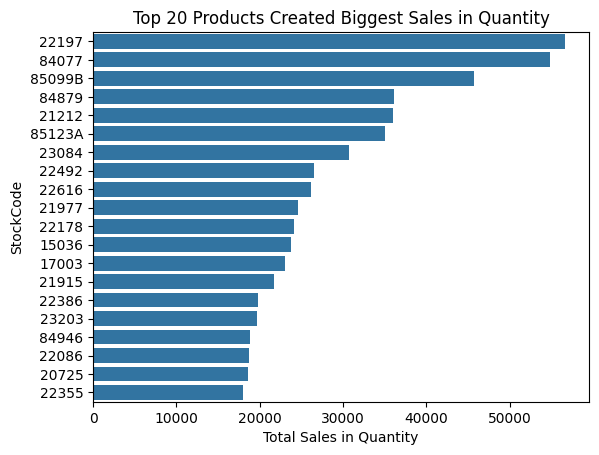

In [28]:
# top 20 products that generated the biggest sales in terms of quantity
most_quantity_products = data_completed_final.groupby('StockCode')['Quantity'].sum()
most_quantity_products = most_quantity_products.sort_values(ascending=False)
most_quantity_products

sns.barplot(y = most_quantity_products[:20].index, x = most_quantity_products[:20].values)
plt.xlabel("Total Sales in Quantity")
plt.ylabel("StockCode")
plt.title("Top 20 Products Created Biggest Sales in Quantity")
plt.show()

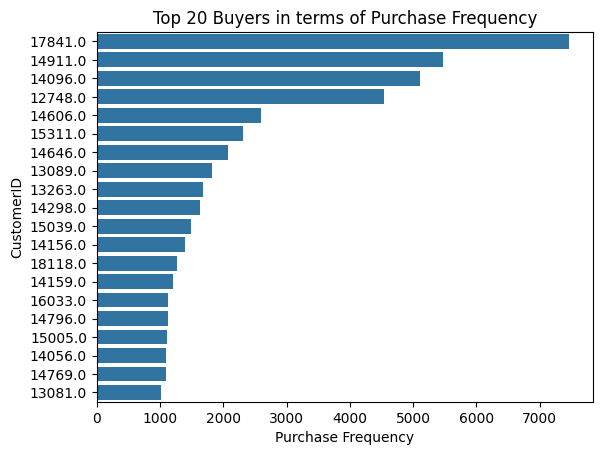

In [29]:
# top 20 buyers in terms of frequency
most_freq_buyers = data_completed_final.groupby('CustomerID')['InvoiceNo'].count()
most_freq_buyers = most_freq_buyers.sort_values(ascending=False)
most_freq_buyers

sns.barplot(y = most_freq_buyers.head(20).index.astype(str), x = most_freq_buyers.head(20).values)
plt.xlabel("Purchase Frequency")
plt.ylabel("CustomerID")
plt.title("Top 20 Buyers in terms of Purchase Frequency")
plt.show()

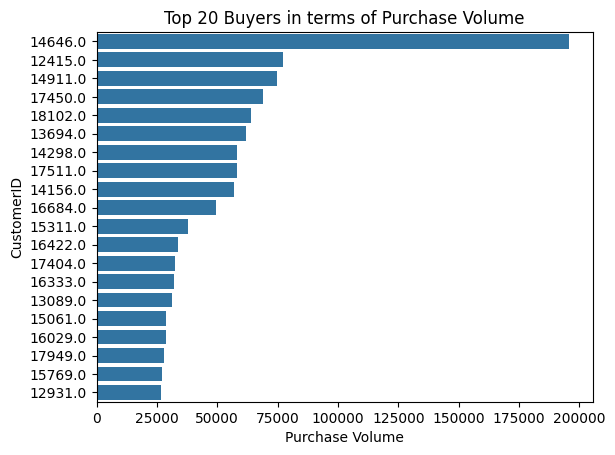

In [30]:
# top 20 buyers in terms of purchase volume
most_purchase_buyers = data_completed_final.groupby('CustomerID')['Quantity'].sum()
most_purchase_buyers = most_purchase_buyers.sort_values(ascending=False)
most_purchase_buyers

sns.barplot(y = most_purchase_buyers.head(20).index.astype(str), x = most_purchase_buyers.head(20).values)
plt.xlabel("Purchase Volume")
plt.ylabel("CustomerID")
plt.title("Top 20 Buyers in terms of Purchase Volume")
plt.show()

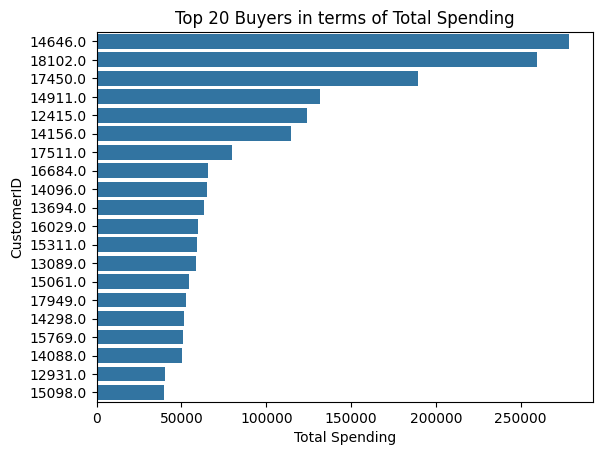

In [31]:
# top 20 buyers in terms of total spending
most_spender_buyers = data_completed_final.groupby('CustomerID')['total_cost'].sum()
most_spender_buyers = most_spender_buyers.sort_values(ascending=False)
most_spender_buyers

sns.barplot(y = most_spender_buyers.head(20).index.astype(str), x = most_spender_buyers.head(20).values)
plt.xlabel("Total Spending")
plt.ylabel("CustomerID")
plt.title("Top 20 Buyers in terms of Total Spending")
plt.show()

# Clustering (Customers)

DBSCAN: Groups points that are closely packed (high-density regions). Two key parameters:
* eps: radius to look for neighbors
* min_samples: minimum number of points to form a dense region

Points are labeled as:
* Core points (enough neighbors within eps)
* Border points (not enough neighbors, but near a core point)
* Noise points (outliers, don’t belong to any cluster)

for each point you check whether there are min_samples points within eps. If there are then this is possible core point however if it is within eps of another core point then instead of starting a new cluster you add that point to that cluster as well if it is not within eps of any core point than it starts a new cluster. Like suppose A is core point and B and C is within eps from A then you add B and C to the cluster as well.

Doesn’t require k. Another advantage is that Kmeans assumes clusters are roughly spherical, similar in size, so when you have U shaped data points Kmeans is not so good at clustering them.

In [66]:
data_completed_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 524971 entries, 0 to 530102
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         524971 non-null  object        
 1   StockCode         524971 non-null  object        
 2   Description       524971 non-null  object        
 3   Quantity          524971 non-null  int64         
 4   InvoiceDate       524971 non-null  datetime64[ns]
 5   UnitPrice         524971 non-null  float64       
 6   CustomerID        393841 non-null  float64       
 7   Country           524971 non-null  object        
 8   Month             524971 non-null  int32         
 9   WeekdayNum        524971 non-null  int32         
 10  WeekdayName       524971 non-null  object        
 11  Week              524971 non-null  UInt32        
 12  status            524971 non-null  object        
 13  key               524971 non-null  object        
 14  row_numbe

In [58]:
data_completed_final[data_completed_final['CustomerID'].isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status,key,row_number,total_cost,InvoiceDate_only
2067,536558,22802,FAUX FUR CHOCOLATE THROW,5,2010-12-01 14:48:00,19.95,NaN,United Kingdom,12,2,Wednesday,48,Completed,0_22802_5_FAUX FUR CHOCOLATE THROW,1,99.75,2010-12-01
1941,536544,90116,FRUIT SALAD BAG CHARM,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom,12,2,Wednesday,48,Completed,0_90116_1_FRUIT SALAD BAG CHARM,1,2.51,2010-12-01
1942,536544,90120C,GREEN MURANO TWIST BRACELET,1,2010-12-01 14:32:00,4.24,NaN,United Kingdom,12,2,Wednesday,48,Completed,0_90120C_1_GREEN MURANO TWIST BRACELET,1,4.24,2010-12-01
1943,536544,90129A,PINK GLASS TASSLE BAG CHARM,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom,12,2,Wednesday,48,Completed,0_90129A_2_PINK GLASS TASSLE BAG CHARM,1,3.32,2010-12-01
1944,536544,90129B,TURQUOISE GLASS TASSLE BAG CHARM,1,2010-12-01 14:32:00,1.66,NaN,United Kingdom,12,2,Wednesday,48,Completed,0_90129B_1_TURQUOISE GLASS TASSLE BAG CHARM,1,1.66,2010-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529015,581492,22866,HAND WARMER SCOTTY DOG DESIGN,3,2011-12-09 10:03:00,4.13,NaN,United Kingdom,12,4,Friday,49,Completed,0_22866_3_HAND WARMER SCOTTY DOG DESIGN,13,12.39,2011-12-09
529014,581492,22865,HAND WARMER OWL DESIGN,2,2011-12-09 10:03:00,4.13,NaN,United Kingdom,12,4,Friday,49,Completed,0_22865_2_HAND WARMER OWL DESIGN,17,8.26,2011-12-09
529013,581492,22835,HOT WATER BOTTLE I AM SO POORLY,3,2011-12-09 10:03:00,10.79,NaN,United Kingdom,12,4,Friday,49,Completed,0_22835_3_HOT WATER BOTTLE I AM SO POORLY,16,32.37,2011-12-09
529012,581492,22821,GIFT BAG PSYCHEDELIC APPLES,3,2011-12-09 10:03:00,0.83,NaN,United Kingdom,12,4,Friday,49,Completed,0_22821_3_GIFT BAG PSYCHEDELIC APPLES,4,2.49,2011-12-09


In [32]:
data_completed_final['Year'] = data_completed_final['InvoiceDate'].dt.year

In [33]:
train_completed_final = data_completed_final[
    (((data_completed_final['Month'] == 12) & (data_completed_final['Year'] == 2010)) |
    (data_completed_final['Month'] <= 6))
]
val_completed_final = data_completed_final[(data_completed_final['Month'] <= 9) & (data_completed_final['Month'] >= 7)]
test_completed_final = data_completed_final[((data_completed_final['Month'] >= 10) & (data_completed_final['Year'] == 2011))]

In [54]:
print(len(train_completed_final) + len(val_completed_final) + len(test_completed_final))
print(len(data_completed_final))

524971
524971


In [34]:
clustering_data = pd.concat([val_completed_final,train_completed_final])

In [35]:
# frequency, total volume, total purchase amount (in terms of cost), 
# avg basket size (total quantity/num of purchase), avg purchase price (total price/num of purchase), 
# Number of unique product categories purchased
end_date = clustering_data['InvoiceDate'].max()

customer_stats = (
    clustering_data
    .groupby('CustomerID')
    .agg(
        frequency=('InvoiceNo', 'nunique'),          
        total_volume=('Quantity', 'sum'),           
        total_purchase_amount=('total_cost', 'sum'),
        last_purchase = ('InvoiceDate', 'max'),
        num_unique_product = ('StockCode', 'nunique')
    )
)

customer_stats['avg_basket_size'] = customer_stats['total_volume']/customer_stats['frequency']
customer_stats['avg_purchase_price'] = customer_stats['total_purchase_amount']/customer_stats['frequency']

# Days since last purchase
customer_stats['days_last_purchase'] = (end_date-customer_stats['last_purchase']).dt.days

customer_stats.head()

,frequency,total_volume,total_purchase_amount,last_purchase,num_unique_product,avg_basket_size,avg_purchase_price,days_last_purchase
CustomerID,,,,,,,,
12347.0,5,1590,2790.86,2011-08-02 08:48:00,82,318.000000,558.172000,59
12348.0,4,2341,1797.24,2011-09-25 13:13:00,22,585.250000,449.310000,5
12350.0,1,197,334.40,2011-02-02 16:01:00,17,197.000000,334.400000,240
12352.0,6,334,2054.18,2011-09-28 14:58:00,47,55.666667,342.363333,2
12353.0,1,20,89.00,2011-05-19 17:47:00,4,20.000000,89.000000,133


In [36]:
data_sorted = clustering_data.sort_values(['CustomerID', 'InvoiceDate'])
data_sorted['prev_InvoiceDate'] = data_sorted.groupby('CustomerID')['InvoiceDate'].shift(1)
# LAG(InvoiceDate) OVER(PARTITON BY CustomerID ORDER BY InvoiceDate) -> SQL version

data_sorted.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status,key,row_number,total_cost,InvoiceDate_only,Year,prev_InvoiceDate
14637,537626,22212,FOUR HOOK WHITE LOVEBIRDS,6,2010-12-07 14:57:00,2.10,12347.0,Iceland,12,1,Tuesday,49,Completed,12347_22212_6_FOUR HOOK WHITE LOVEBIRDS,1,12.6,2010-12-07,2010,NaT
14638,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,12347.0,Iceland,12,1,Tuesday,49,Completed,12347_22375_4_AIRLINE BAG VINTAGE JET SET BROWN,1,17.0,2010-12-07,2010,2010-12-07 14:57:00
14639,537626,22492,MINI PAINT SET VINTAGE,36,2010-12-07 14:57:00,0.65,12347.0,Iceland,12,1,Tuesday,49,Completed,12347_22492_36_MINI PAINT SET VINTAGE,1,23.4,2010-12-07,2010,2010-12-07 14:57:00
14640,537626,22494,EMERGENCY FIRST AID TIN,12,2010-12-07 14:57:00,1.25,12347.0,Iceland,12,1,Tuesday,49,Completed,12347_22494_12_EMERGENCY FIRST AID TIN,1,15.0,2010-12-07,2010,2010-12-07 14:57:00
14641,537626,22497,SET OF 2 TINS VINTAGE BATHROOM,4,2010-12-07 14:57:00,4.25,12347.0,Iceland,12,1,Tuesday,49,Completed,12347_22497_4_SET OF 2 TINS VINTAGE BATHROOM,1,17.0,2010-12-07,2010,2010-12-07 14:57:00


In [38]:
# Average time between purchases
data_sorted['days_between'] = (data_sorted['InvoiceDate'] - data_sorted['prev_InvoiceDate']).dt.days

avg_days_between = data_sorted.groupby('CustomerID')['days_between'].mean()
avg_days_between.head()

CustomerID
12347.0    1.910569
12348.0    9.400000
12350.0    0.000000
12352.0    3.655738
12353.0    0.000000
Name: days_between, dtype: float64

In [39]:
customer_stats = customer_stats.merge(avg_days_between, how = "inner", on = 'CustomerID')
customer_stats.rename(columns={'days_between': 'avg_days_between'}, inplace = True)
customer_stats.head()

,frequency,total_volume,total_purchase_amount,last_purchase,num_unique_product,avg_basket_size,avg_purchase_price,days_last_purchase,avg_days_between
CustomerID,,,,,,,,,
12347.0,5,1590,2790.86,2011-08-02 08:48:00,82,318.000000,558.172000,59,1.910569
12348.0,4,2341,1797.24,2011-09-25 13:13:00,22,585.250000,449.310000,5,9.400000
12350.0,1,197,334.40,2011-02-02 16:01:00,17,197.000000,334.400000,240,0.000000
12352.0,6,334,2054.18,2011-09-28 14:58:00,47,55.666667,342.363333,2,3.655738
12353.0,1,20,89.00,2011-05-19 17:47:00,4,20.000000,89.000000,133,0.000000


In [40]:
customer_stats['avg_days_between'] = customer_stats['avg_days_between'].fillna(0.0)
customer_stats.head()

,frequency,total_volume,total_purchase_amount,last_purchase,num_unique_product,avg_basket_size,avg_purchase_price,days_last_purchase,avg_days_between
CustomerID,,,,,,,,,
12347.0,5,1590,2790.86,2011-08-02 08:48:00,82,318.000000,558.172000,59,1.910569
12348.0,4,2341,1797.24,2011-09-25 13:13:00,22,585.250000,449.310000,5,9.400000
12350.0,1,197,334.40,2011-02-02 16:01:00,17,197.000000,334.400000,240,0.000000
12352.0,6,334,2054.18,2011-09-28 14:58:00,47,55.666667,342.363333,2,3.655738
12353.0,1,20,89.00,2011-05-19 17:47:00,4,20.000000,89.000000,133,0.000000


In [41]:
features = [
    'frequency', 'total_volume', 'total_purchase_amount',
    'num_unique_product', 'avg_basket_size',
    'avg_purchase_price', 'days_last_purchase', 'avg_days_between'
]

X = customer_stats[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dbscan = DBSCAN(eps=1.5, min_samples=10) # in the neighbor if their Euclidean distance ≤ 1.5 in the standardized feature space. There must be at least 10 points within the neighbor/radius to form a cluster
labels = dbscan.fit_predict(X_scaled)

customer_stats['cluster'] = labels

print(customer_stats['cluster'].value_counts())

cluster
 0    3516
-1      92
Name: count, dtype: int64


In [42]:
customer_stats.drop('cluster', axis = 1, inplace = True)

dbscan = DBSCAN(eps=1.0, min_samples=10) # in the neighbor if their Euclidean distance ≤ 1.5 in the standardized feature space. There must be at least 10 points within the neighbor/radius to form a cluster
labels = dbscan.fit_predict(X_scaled)

customer_stats['cluster'] = labels

print(customer_stats['cluster'].value_counts())

cluster
 0    3448
-1     160
Name: count, dtype: int64


Even though we reduced the epsilon instead of forming new clusters DBSCAN assigned more records as outliers. It might be the case that data in 8D space forms a spherical clusters. In that case instead of DBSCAN other clustering algorithms might be more efficient

# Dimension Reduction

PCA in 2D will compute the covariance matrix of the data and find its eigenvectors these are the directions that remain unchanged in direction after covariance matrix distorts the space. The corresponding eigenvalues tell us how much variance the data has along each of those directions.
PCA selects the eigenvectors with the largest eigenvalues (in this case, the top 2), because they capture the directions of maximum variance, i.e. the directions that contain the most information in the data.
These eigenvectors form the new axes, and projecting the data onto them gives us a lower-dimensional representation that preserves as much variance as possible.

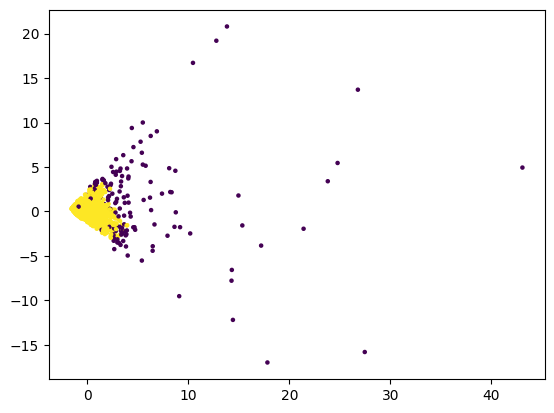

In [66]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap='viridis', s=5)

t-SNE is another dimension reduction method however unlike PCA it does not assume linear structure. It converts high-dimensional (refers to feature space) distances to probabilities. t-SNE looks at its neighbors and converts Euclidean distances into conditional probabilities that measure, how likely is xj to be a neighbor of xi. It uses a Gaussian distribution around each point. Does a similar thing at low dimensional space (in this case 2D space that t-SNE outputs for visualization) and this time uses Student t-distribution. Lastly t-SNE tries to find 2D positions yi that make the low-dimensional probabilities qij as similar as possible to the high-dimensional probabilities pij. It does this by minimizing the Kullback–Leibler divergence

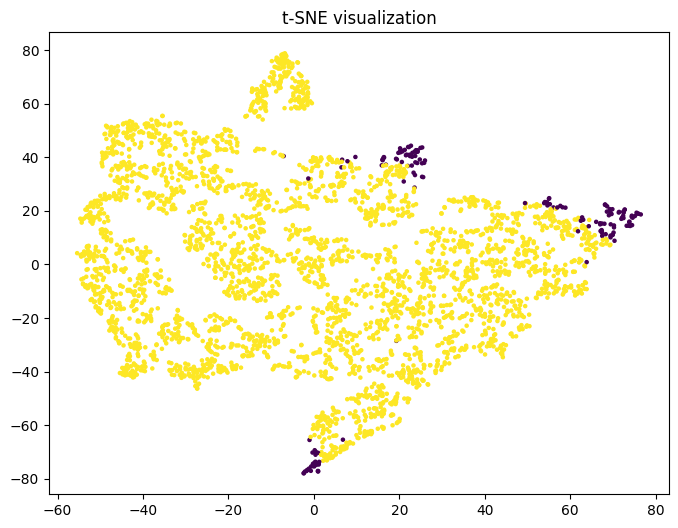

In [67]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=5)
plt.title('t-SNE visualization')
plt.show()

there are no clear clusters based on the feature space we have created. However we can proceed to create clusters nonetheless using KMeans. We can create 3 clusters. Maybe after looking at summary statistics we can find some meaningful clusters.

In [43]:
customer_stats.drop('cluster', axis = 1, inplace = True)

kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
customer_stats['cluster'] = kmeans.fit_predict(X_scaled)

In [44]:
customer_stats.value_counts('cluster')

cluster
2    2231
1    1351
0      26
Name: count, dtype: int64

In [45]:
cluster_summary = customer_stats.groupby('cluster')[features].mean().round(2)
display(cluster_summary)
# we actually got meaningful clusters

,frequency,total_volume,total_purchase_amount,num_unique_product,avg_basket_size,avg_purchase_price,days_last_purchase,avg_days_between
cluster,,,,,,,,
0,43.42,32993.46,58476.91,362.19,1550.05,3140.43,18.92,1.74
1,1.48,210.73,402.12,23.02,146.98,277.61,186.95,1.07
2,4.44,1048.70,1748.52,65.87,261.40,418.71,35.59,3.68


In [46]:
cluster_map = {0: 'VIP',
               1: 'casual',
               2: 'loyal'}

In [47]:
customer_stats['cluster'] = customer_stats['cluster'].map(cluster_map)
customer_stats.head()

,frequency,total_volume,total_purchase_amount,last_purchase,num_unique_product,avg_basket_size,avg_purchase_price,days_last_purchase,avg_days_between,cluster
CustomerID,,,,,,,,,,
12347.0,5,1590,2790.86,2011-08-02 08:48:00,82,318.000000,558.172000,59,1.910569,loyal
12348.0,4,2341,1797.24,2011-09-25 13:13:00,22,585.250000,449.310000,5,9.400000,loyal
12350.0,1,197,334.40,2011-02-02 16:01:00,17,197.000000,334.400000,240,0.000000,casual
12352.0,6,334,2054.18,2011-09-28 14:58:00,47,55.666667,342.363333,2,3.655738,loyal
12353.0,1,20,89.00,2011-05-19 17:47:00,4,20.000000,89.000000,133,0.000000,casual


but because there are lots of records where customerID is missing we will not be able to use this clustering in the final prediction model

# Clustering (Products)

In [48]:
product_stats = (
    clustering_data
    .groupby('StockCode')
    .agg(
        frequency=('InvoiceNo', 'nunique'),
        total_volume=('Quantity', 'sum'),
        total_purchase_amount=('total_cost', 'sum'),
        num_unique_customer=('CustomerID', 'nunique')
    )
)

product_stats['avg_basket_size'] = product_stats['total_volume'] / product_stats['frequency']
product_stats['avg_purchase_price'] = product_stats['total_purchase_amount'] / product_stats['frequency']

In [74]:
product_stats.head()

,frequency,total_volume,total_purchase_amount,num_unique_customer,avg_basket_size,avg_purchase_price
StockCode,,,,,,
10002,71,860,759.89,40,12.112676,10.702676
10080,13,206,81.26,12,15.846154,6.250769
10120,18,128,26.88,18,7.111111,1.493333
10123C,3,5,3.25,3,1.666667,1.083333
10124A,4,12,5.04,4,3.000000,1.260000


In [49]:
features = [
    'frequency', 'total_volume', 'total_purchase_amount',
    'num_unique_customer', 'avg_basket_size',
    'avg_purchase_price'
]

X = product_stats[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dbscan = DBSCAN(eps=1.5, min_samples=10) # in the neighbor if their Euclidean distance ≤ 1.5 in the standardized feature space. There must be at least 10 points within the neighbor/radius to form a cluster
labels = dbscan.fit_predict(X_scaled)

product_stats['cluster'] = labels

print(product_stats['cluster'].value_counts())

cluster
 0    3683
-1      55
Name: count, dtype: int64


In [67]:
product_stats.drop('cluster', axis = 1, inplace = True)

dbscan = DBSCAN(eps=0.3, min_samples=10) # in the neighbor if their Euclidean distance ≤ 1.5 in the standardized feature space. There must be at least 10 points within the neighbor/radius to form a cluster
labels = dbscan.fit_predict(X_scaled)

product_stats['cluster'] = labels

print(product_stats['cluster'].value_counts())

cluster
 0    3077
-1     650
 1      11
Name: count, dtype: int64


Again lets try to visualize the records in feature space using dimension reduction methods

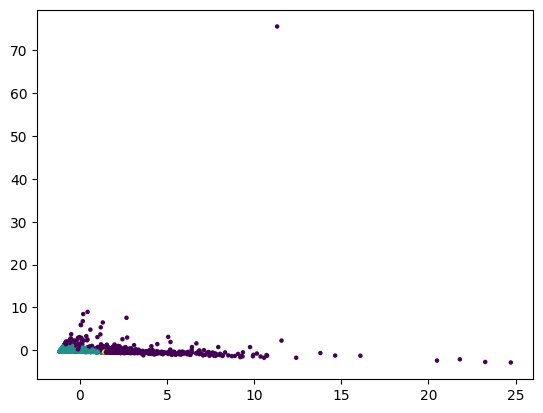

In [77]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap='viridis', s=5)

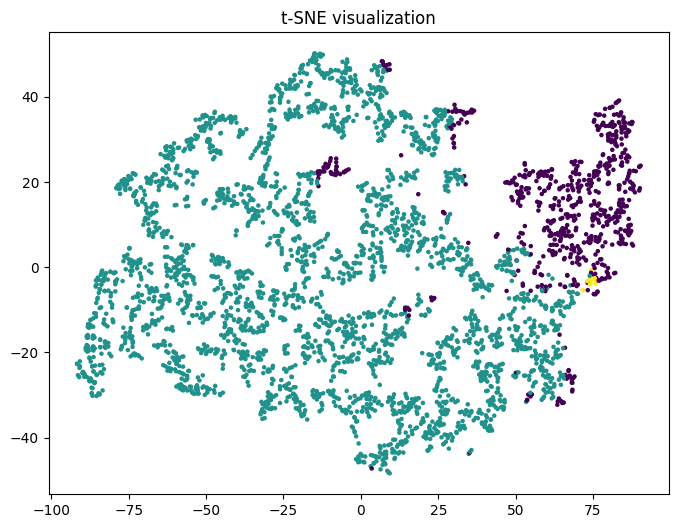

In [78]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=5)
plt.title('t-SNE visualization')
plt.show()

In [50]:
product_stats.drop('cluster', axis = 1, inplace = True)
kmeans = KMeans(n_clusters=3, init="k-means++", random_state=42)
product_stats['cluster'] = kmeans.fit_predict(X_scaled)

In [51]:
product_stats.value_counts('cluster')

cluster
2    3374
0     363
1       1
Name: count, dtype: int64

In [52]:
cluster_summary = product_stats.groupby('cluster')[features].mean().round(2)
display(cluster_summary)

,frequency,total_volume,total_purchase_amount,num_unique_customer,avg_basket_size,avg_purchase_price
cluster,,,,,,
0,426.87,5581.77,11361.91,213.64,14.70,26.0
1,2.00,2600.00,6045.00,1.00,1300.00,3022.5
2,58.58,512.42,861.71,32.58,8.03,14.2


In [53]:
cluster_map = {0: 'popular',
               1: 'casual',
               2: 'casual'}

product_stats['cluster'] = product_stats['cluster'].map(cluster_map)
product_stats.head()

,frequency,total_volume,total_purchase_amount,num_unique_customer,avg_basket_size,avg_purchase_price,cluster
StockCode,,,,,,,
10002,71,860,759.89,40,12.112676,10.702676,casual
10080,13,206,81.26,12,15.846154,6.250769,casual
10120,18,128,26.88,18,7.111111,1.493333,casual
10123C,3,5,3.25,3,1.666667,1.083333,casual
10124A,4,12,5.04,4,3.000000,1.260000,casual


# Prediction (Total Units)

In [109]:
# Sales yesterday (lag 1), Sales 7 days before (lag 7), Sales 14 days before (lag 14)
# Average in last week (7 days), Average in 4 weeks (28 days), Average in last 8 weeks (56 days)
data_completed_final_cluster = data_completed_final.merge(product_stats.reset_index()[['StockCode', 'cluster']], how = "inner", on = "StockCode")
data_completed_final_cluster.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,WeekdayNum,WeekdayName,Week,status,key,row_number,total_cost,InvoiceDate_only,Year,cluster
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,12,2,Wednesday,48,Completed,17850_21730_6_GLASS STAR FROSTED T-LIGHT HOLDER,1,25.50,2010-12-01,2010,casual
1,536557,22686,FRENCH BLUE METAL DOOR SIGN No,1,2010-12-01 14:41:00,1.25,17841.0,United Kingdom,12,2,Wednesday,48,Completed,17841_22686_1_FRENCH BLUE METAL DOOR SIGN No,1,1.25,2010-12-01,2010,casual
2,536557,22694,WICKER STAR,2,2010-12-01 14:41:00,2.10,17841.0,United Kingdom,12,2,Wednesday,48,Completed,17841_22694_2_WICKER STAR,1,4.20,2010-12-01,2010,casual
3,536557,22730,ALARM CLOCK BAKELIKE IVORY,1,2010-12-01 14:41:00,3.75,17841.0,United Kingdom,12,2,Wednesday,48,Completed,17841_22730_1_ALARM CLOCK BAKELIKE IVORY,1,3.75,2010-12-01,2010,popular
4,536557,22731,3D CHRISTMAS STAMPS STICKERS,1,2010-12-01 14:41:00,1.25,17841.0,United Kingdom,12,2,Wednesday,48,Completed,17841_22731_1_3D CHRISTMAS STAMPS STICKERS,1,1.25,2010-12-01,2010,casual


In [110]:
data_completed_final_cluster_grouped = (data_completed_final_cluster.groupby(
    ['StockCode', 'Country', 'cluster', 'InvoiceDate_only', 'Year', 'Month', 'Week', 'WeekdayNum']
).agg(
    total_volume=('Quantity', 'sum'),
    total_sales_price=('total_cost', 'sum')
).reset_index())


In [112]:
data_completed_final_cluster_grouped = data_completed_final_cluster_grouped.sort_values(['StockCode', 'Country', 'InvoiceDate_only'])

data_completed_final_cluster_grouped = (
    data_completed_final_cluster_grouped
      .groupby(['StockCode','Country','cluster'], group_keys=False)
      .apply(calendar_fillzero)
)

C:\Users\mertk\AppData\Local\Temp\ipykernel_17428\2704028296.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calendar_fillzero)


In [113]:
data_completed_final_cluster_grouped.head()

,InvoiceDate_only,StockCode,Country,cluster,Year,Month,Week,WeekdayNum,total_volume,total_sales_price
0,2010-12-10,10002,EIRE,casual,2010,12,49,4,12.0,10.2
0,2010-12-01,10002,France,casual,2010,12,48,2,48.0,40.8
1,2010-12-02,10002,France,casual,2010,12,48,3,0.0,0.0
2,2010-12-03,10002,France,casual,2010,12,48,4,0.0,0.0
3,2010-12-04,10002,France,casual,2010,12,48,5,0.0,0.0


In [114]:
data_completed_final_cluster_grouped[(data_completed_final_cluster_grouped['StockCode'] == "10002") & (data_completed_final_cluster_grouped['Country'] == 'France')]

,InvoiceDate_only,StockCode,Country,cluster,Year,Month,Week,WeekdayNum,total_volume,total_sales_price
0,2010-12-01,10002,France,casual,2010,12,48,2,48.0,40.8
1,2010-12-02,10002,France,casual,2010,12,48,3,0.0,0.0
2,2010-12-03,10002,France,casual,2010,12,48,4,0.0,0.0
3,2010-12-04,10002,France,casual,2010,12,48,5,0.0,0.0
4,2010-12-05,10002,France,casual,2010,12,48,6,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
117,2011-03-28,10002,France,casual,2011,3,13,0,0.0,0.0
118,2011-03-29,10002,France,casual,2011,3,13,1,0.0,0.0
119,2011-03-30,10002,France,casual,2011,3,13,2,0.0,0.0
120,2011-03-31,10002,France,casual,2011,3,13,3,0.0,0.0


In [115]:
data_completed_final_cluster_grouped_lagged = data_completed_final_cluster_grouped.copy()
for c in ['total_volume', 'total_sales_price']:
    for L in [1, 7, 14]:
        data_completed_final_cluster_grouped_lagged = lag_day(data_completed_final_cluster_grouped_lagged, colname = c, lag=L)


In [116]:
data_completed_final_cluster_grouped_lagged.head()

,InvoiceDate_only,StockCode,Country,cluster,Year,Month,Week,WeekdayNum,total_volume,total_sales_price,lag_total_volume_1,lag_total_volume_7,lag_total_volume_14,lag_total_sales_price_1,lag_total_sales_price_7,lag_total_sales_price_14
0,2010-12-10,10002,EIRE,casual,2010,12,49,4,12.0,10.2,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-12-01,10002,France,casual,2010,12,48,2,48.0,40.8,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-12-02,10002,France,casual,2010,12,48,3,0.0,0.0,48.0,0.0,0.0,40.8,0.0,0.0
3,2010-12-03,10002,France,casual,2010,12,48,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-12-04,10002,France,casual,2010,12,48,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
df = data_completed_final_cluster_grouped_lagged.sort_values(['StockCode', 'Country', 'InvoiceDate_only'])
for c in ['total_volume', 'total_sales_price']:
    for l in [7, 28, 56]:
        df = (df.groupby(['StockCode', 'Country'], group_keys=False)
            .apply(lambda g: lag_avg(g, colname = c, lag=l)))
data_completed_final_cluster_grouped_lagged = df


C:\Users\mertk\AppData\Local\Temp\ipykernel_17428\4122309126.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: lag_avg(g, colname = c, lag=l)))
C:\Users\mertk\AppData\Local\Temp\ipykernel_17428\4122309126.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: lag_avg(g, colname = c, lag=l)))
C:\Users\mertk\AppData\Local\Temp\ipykernel_17428\4122309126.py:5: DeprecationWarnin

In [118]:
data_completed_final_cluster_grouped_lagged.head()

,InvoiceDate_only,StockCode,Country,cluster,Year,Month,Week,WeekdayNum,total_volume,total_sales_price,...,lag_total_volume_14,lag_total_sales_price_1,lag_total_sales_price_7,lag_total_sales_price_14,avg_total_volume_7,avg_total_volume_28,avg_total_volume_56,avg_total_sales_price_7,avg_total_sales_price_28,avg_total_sales_price_56
0,2010-12-10,10002,EIRE,casual,2010,12,49,4,12.0,10.2,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-12-01,10002,France,casual,2010,12,48,2,48.0,40.8,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-12-02,10002,France,casual,2010,12,48,3,0.0,0.0,...,0.0,40.8,0.0,0.0,48.0,48.0,48.0,40.8,40.8,40.8
3,2010-12-03,10002,France,casual,2010,12,48,4,0.0,0.0,...,0.0,0.0,0.0,0.0,24.0,24.0,24.0,20.4,20.4,20.4
4,2010-12-04,10002,France,casual,2010,12,48,5,0.0,0.0,...,0.0,0.0,0.0,0.0,16.0,16.0,16.0,13.6,13.6,13.6


In [119]:
data_completed_final_cluster_grouped_lagged[(data_completed_final_cluster_grouped_lagged['StockCode'] == "10002") & (data_completed_final_cluster_grouped_lagged['Country'] == 'France')].head(10)

,InvoiceDate_only,StockCode,Country,cluster,Year,Month,Week,WeekdayNum,total_volume,total_sales_price,...,lag_total_volume_14,lag_total_sales_price_1,lag_total_sales_price_7,lag_total_sales_price_14,avg_total_volume_7,avg_total_volume_28,avg_total_volume_56,avg_total_sales_price_7,avg_total_sales_price_28,avg_total_sales_price_56
1,2010-12-01,10002,France,casual,2010,12,48,2,48.0,40.8,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-12-02,10002,France,casual,2010,12,48,3,0.0,0.0,...,0.0,40.8,0.0,0.0,48.000000,48.000000,48.000000,40.800000,40.800000,40.800000
3,2010-12-03,10002,France,casual,2010,12,48,4,0.0,0.0,...,0.0,0.0,0.0,0.0,24.000000,24.000000,24.000000,20.400000,20.400000,20.400000
4,2010-12-04,10002,France,casual,2010,12,48,5,0.0,0.0,...,0.0,0.0,0.0,0.0,16.000000,16.000000,16.000000,13.600000,13.600000,13.600000
5,2010-12-05,10002,France,casual,2010,12,48,6,0.0,0.0,...,0.0,0.0,0.0,0.0,12.000000,12.000000,12.000000,10.200000,10.200000,10.200000
6,2010-12-06,10002,France,casual,2010,12,49,0,0.0,0.0,...,0.0,0.0,0.0,0.0,9.600000,9.600000,9.600000,8.160000,8.160000,8.160000
7,2010-12-07,10002,France,casual,2010,12,49,1,0.0,0.0,...,0.0,0.0,0.0,0.0,8.000000,8.000000,8.000000,6.800000,6.800000,6.800000
8,2010-12-08,10002,France,casual,2010,12,49,2,0.0,0.0,...,0.0,0.0,40.8,0.0,6.857143,6.857143,6.857143,5.828571,5.828571,5.828571
9,2010-12-09,10002,France,casual,2010,12,49,3,12.0,10.2,...,0.0,0.0,0.0,0.0,0.000000,6.000000,6.000000,0.000000,5.100000,5.100000
10,2010-12-10,10002,France,casual,2010,12,49,4,36.0,30.6,...,0.0,10.2,0.0,0.0,1.714286,6.666667,6.666667,1.457143,5.666667,5.666667


In [120]:
data_completed_final_cluster_grouped_lagged.isna().sum()

InvoiceDate_only                0
StockCode                       0
Country                         0
cluster                         0
Year                            0
Month                           0
Week                            0
WeekdayNum                      0
total_volume                    0
total_sales_price               0
lag_total_volume_1              0
lag_total_volume_7              0
lag_total_volume_14             0
lag_total_sales_price_1         0
lag_total_sales_price_7         0
lag_total_sales_price_14        0
avg_total_volume_7          18931
avg_total_volume_28         18931
avg_total_volume_56         18931
avg_total_sales_price_7     18931
avg_total_sales_price_28    18931
avg_total_sales_price_56    18931
dtype: int64

In [125]:
data_completed_final_cluster_grouped_lagged['avg_total_volume_7'] = data_completed_final_cluster_grouped_lagged['avg_total_volume_7'].fillna(0)
data_completed_final_cluster_grouped_lagged['avg_total_volume_28'] = data_completed_final_cluster_grouped_lagged['avg_total_volume_28'].fillna(0)
data_completed_final_cluster_grouped_lagged['avg_total_volume_56'] = data_completed_final_cluster_grouped_lagged['avg_total_volume_56'].fillna(0)
data_completed_final_cluster_grouped_lagged['avg_total_sales_price_7'] = data_completed_final_cluster_grouped_lagged['avg_total_sales_price_7'].fillna(0)
data_completed_final_cluster_grouped_lagged['avg_total_sales_price_28'] = data_completed_final_cluster_grouped_lagged['avg_total_sales_price_28'].fillna(0)
data_completed_final_cluster_grouped_lagged['avg_total_sales_price_56'] = data_completed_final_cluster_grouped_lagged['avg_total_sales_price_56'].fillna(0)

In [126]:
data_completed_final_cluster_grouped_lagged.head()

,InvoiceDate_only,StockCode,Country,cluster,Year,Month,Week,WeekdayNum,total_volume,total_sales_price,...,lag_total_volume_14,lag_total_sales_price_1,lag_total_sales_price_7,lag_total_sales_price_14,avg_total_volume_7,avg_total_volume_28,avg_total_volume_56,avg_total_sales_price_7,avg_total_sales_price_28,avg_total_sales_price_56
0,2010-12-10,10002,EIRE,casual,2010,12,49,4,12.0,10.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-12-01,10002,France,casual,2010,12,48,2,48.0,40.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-12-02,10002,France,casual,2010,12,48,3,0.0,0.0,...,0.0,40.8,0.0,0.0,40.8,40.8,40.8,40.8,40.8,40.8
3,2010-12-03,10002,France,casual,2010,12,48,4,0.0,0.0,...,0.0,0.0,0.0,0.0,20.4,20.4,20.4,20.4,20.4,20.4
4,2010-12-04,10002,France,casual,2010,12,48,5,0.0,0.0,...,0.0,0.0,0.0,0.0,13.6,13.6,13.6,13.6,13.6,13.6


In [127]:
train_completed_final = data_completed_final_cluster_grouped_lagged[
    (((data_completed_final_cluster_grouped_lagged['Month'] == 12) & (data_completed_final_cluster_grouped_lagged['Year'] == 2010)) |
    (data_completed_final_cluster_grouped_lagged['Month'] <= 6))
]
val_completed_final = data_completed_final_cluster_grouped_lagged[(data_completed_final_cluster_grouped_lagged['Month'] <= 9) & (data_completed_final_cluster_grouped_lagged['Month'] >= 7)]
test_completed_final = data_completed_final_cluster_grouped_lagged[((data_completed_final_cluster_grouped_lagged['Month'] >= 10) & (data_completed_final_cluster_grouped_lagged['Year'] == 2011))]

In [128]:
train_completed_final.head()

,InvoiceDate_only,StockCode,Country,cluster,Year,Month,Week,WeekdayNum,total_volume,total_sales_price,...,lag_total_volume_14,lag_total_sales_price_1,lag_total_sales_price_7,lag_total_sales_price_14,avg_total_volume_7,avg_total_volume_28,avg_total_volume_56,avg_total_sales_price_7,avg_total_sales_price_28,avg_total_sales_price_56
0,2010-12-10,10002,EIRE,casual,2010,12,49,4,12.0,10.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-12-01,10002,France,casual,2010,12,48,2,48.0,40.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-12-02,10002,France,casual,2010,12,48,3,0.0,0.0,...,0.0,40.8,0.0,0.0,40.8,40.8,40.8,40.8,40.8,40.8
3,2010-12-03,10002,France,casual,2010,12,48,4,0.0,0.0,...,0.0,0.0,0.0,0.0,20.4,20.4,20.4,20.4,20.4,20.4
4,2010-12-04,10002,France,casual,2010,12,48,5,0.0,0.0,...,0.0,0.0,0.0,0.0,13.6,13.6,13.6,13.6,13.6,13.6


In [ ]:
X_train = train_completed_final[['StockCode', 'Country', 'cluster', 'Year', 'Month', 'Week', 'WeekdayNum', 'total_volume', 'total_sales_price', 'lag_1', 'lag_7', 'lag_14', 'avg_7', 'avg_28', 'avg_56']]

X_train['weekday_sin'] = np.sin(2 * np.pi * X_train['WeekdayNum'] / 7)
X_train['weekday_cos'] = np.cos(2 * np.pi * X_train['WeekdayNum'] / 7)
X_train['month_sin'] = np.sin(2 * np.pi * X_train['Month'] / 12)
X_train['month_cos'] = np.cos(2 * np.pi * X_train['Month'] / 12)

y_train_quant = X_train['total_volume']

X_train.drop(['Month', 'Week', 'WeekdayNum', 'total_volume', 'total_sales_price'], axis = 1, inplace = True)

In [104]:
X_train.head()

,StockCode,Country,cluster,Year,weekday_sin,weekday_cos,month_sin,month_cos
0,10002,EIRE,casual,2010,-0.433884,-0.900969,-2.449294e-16,1.000000
1,10002,France,casual,2010,0.974928,-0.222521,-2.449294e-16,1.000000
2,10002,France,casual,2010,0.433884,-0.900969,-2.449294e-16,1.000000
3,10002,France,casual,2010,-0.433884,-0.900969,-2.449294e-16,1.000000
4,10002,France,casual,2011,0.974928,-0.222521,5.000000e-01,0.866025
